In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from scipy.stats import beta, bernoulli
import numpy as np

In [2]:
def dummy_genrator(conversion_rate, n_impression):
    return np.array(bernoulli(conversion_rate).rvs(n_impression))

In [3]:
a = dummy_genrator(0.015, 204)
b = dummy_genrator(0.021, 200)
imp_a = len(a)
imp_b = len(b)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))

A 
表示数: 204
購入数: 2

B 
表示数: 200
購入数: 3



In [4]:
class BayesianAB:
    
    def __init__(self, params=None, size=2):
        """
            params are a list of Beta distribution's initial params. e.g. [[alpha of A, beta of A], [alpha of B, beta of B]]
        """
        if params is None:
            self.params = []
            for _ in range(size):
                self.params.append([1,1])
        self.size = len(self.params)
        self.data = []
        for _ in range(size):
            self.data.append([0,0])
        print("the number of comparison: ", self.size)
        self.sampling()
        
    def update(self, data, sampling=True):
        """
         data are a list of pairs of impression and conversion. e.g. [[imp of A, conv of A], [imp of B, conv of B]]
        """
        if self.size != len(data):
            print("No match of the size.")
        
        for p, current, new in zip(self.params, self.data, data):
            imp = new[0]
            conv = new[1]
            current[0] += imp
            current[1] += conv
            p[0] += conv
            p[1] += (imp - conv)
        if sampling:
            self.sampling()
        
        
    def mean_ver(self):
        """
            return [(mean of A, variance of A), (mean of B, variance of B), ...]
        """
        return  [(posterior.mean(), posterior.var())for posterior in self.posterior_list]

        
        
    def sampling(self, n_samples=50000):
        print("num of samples: ", n_samples)
        self.posterior_list = [beta(*p).rvs(n_samples) for p in self.params]


        
    def show_beta(self, title="", save=False, labels=None):
        
        plt.figure(figsize=(10, 5))
        plt.title("Posterior distribution "+ title)
        
        cmap = plt.get_cmap('jet')
        color_list= []
            
        for i, posterior in enumerate(self.posterior_list):
            color =cmap(0.25*(i+1))
            color_list.append(color)
            plt.hist(posterior, bins=100, histtype="stepfilled", normed=True, color=color, alpha=0.5)
        handles = [Rectangle((0,0),1,1,color=c, ec="k", alpha=0.5) for c in color_list]
        
        if labels is None:
            labels = [chr(65+i) for i in range(self.size)] # create A,B,...
            

        plt.legend(handles, labels)
        if save:
            plt.savefig("{}.png".format(title))
        plt.show()
    
    def diff_prob(self, index_high, index_low):
        prob = (self.posterior_list[index_low] < self.posterior_list[index_high]).mean()
        if prob < 0.5:
            prob = 1 - prob
        return prob
    
    def show_metrics(self):
        print(self.data)
        
    def metrics(self, labels=None):
        if labels is None:
            labels = [chr(65+i) for i in range(self.size)] # create A,B,...
        return pd.DataFrame(self.data, index=labels, columns=["Impressions", "Conversions"])
        

In [5]:
abtest = BayesianAB()

the number of comparison:  2
num of samples:  50000


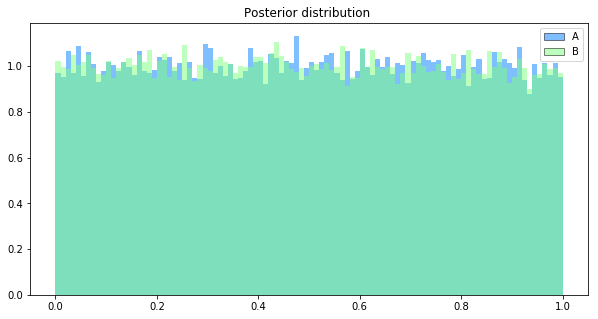

In [6]:
abtest.show_beta()

In [7]:
abtest.update([[imp_a, conv_a], [imp_b, conv_b]])

num of samples:  50000


In [8]:
abtest.mean_ver()

[(0.014610260919694517, 7.003148406424335e-05),
 (0.019850764074203515, 9.568870563433339e-05)]

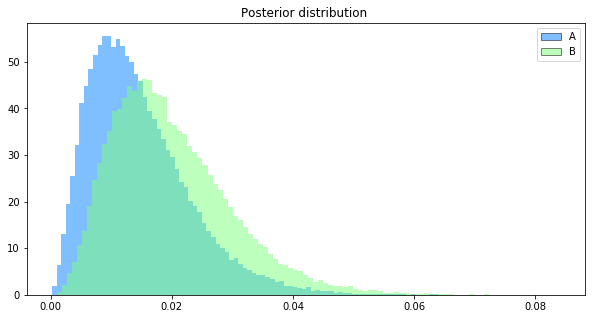

In [9]:
abtest.show_beta()

In [10]:
abtest.diff_prob(0,1)

0.6682600000000001

In [11]:
abtest.show_metrics()

[[204, 2], [200, 3]]


In [12]:
a = dummy_genrator(0.015, 20400)
b = dummy_genrator(0.021, 20000)
imp_a = len(a)
imp_b = len(b)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))

A 
表示数: 20400
購入数: 337

B 
表示数: 20000
購入数: 433



In [13]:
abtest.update([[imp_a, conv_a], [imp_b, conv_b]])

num of samples:  50000


In [14]:
abtest.show_metrics()

[[20604, 339], [20200, 436]]


In [15]:
abtest.metrics()

,Impressions,Conversions
A,20604,339
B,20200,436


In [31]:
a = dummy_genrator(0.015, 1002)
b = dummy_genrator(0.021, 1200)
c = dummy_genrator(0.016, 1130)
imp_a = len(a)
imp_b = len(b)
imp_c = len(c)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
conv_c = np.count_nonzero(c)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))
print("C \n表示数: {}\n購入数: {}\n".format(imp_c, conv_c))

A 
表示数: 1002
購入数: 22

B 
表示数: 1200
購入数: 22

C 
表示数: 1130
購入数: 18



the number of comparison:  3
num of samples:  50000
num of samples:  50000


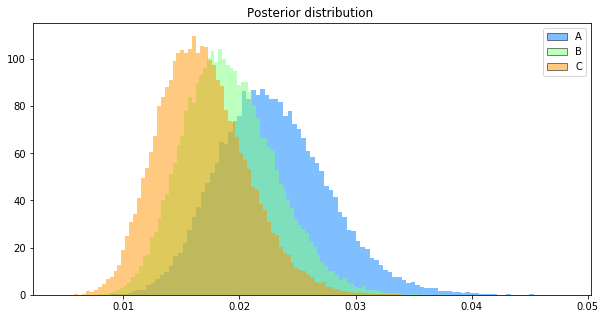

In [32]:
abtest = BayesianAB(size=3)
abtest.update([[imp_a, conv_a], [imp_b, conv_b],[imp_c, conv_c]])
abtest.show_beta()
#abtest.diff_prob()

In [33]:
abtest.metrics()

,Impressions,Conversions
A,1002,22
B,1200,22
C,1130,18


In [34]:
abtest.diff_prob(1,0)

0.72712

In [35]:
abtest.diff_prob(1,2)

0.66822

In [36]:
abtest.diff_prob(2,0)

0.84508

In [37]:
a = dummy_genrator(0.015, 25100)
b = dummy_genrator(0.021, 22000)
c = dummy_genrator(0.016, 23300)
imp_a = len(a)
imp_b = len(b)
imp_c = len(c)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
conv_c = np.count_nonzero(c)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))
print("B \n表示数: {}\n購入数: {}\n".format(imp_c, conv_c))

A 
表示数: 25100
購入数: 364

B 
表示数: 22000
購入数: 469

B 
表示数: 23300
購入数: 354



num of samples:  50000


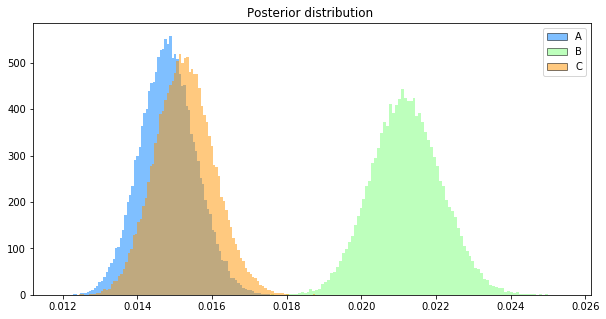

[(0.014823136368344494, 5.586078465062482e-07),
 (0.0212059201285066, 8.839507467322899e-07),
 (0.01526854730312879, 6.223394152971891e-07)]

In [38]:
abtest.update([[imp_a, conv_a], [imp_b, conv_b],[imp_c, conv_c]])
abtest.show_beta()
abtest.mean_ver()

In [39]:
abtest.metrics()

,Impressions,Conversions
A,26102,386
B,23200,491
C,24430,372


In [40]:
abtest.diff_prob(1,0)

1.0

In [41]:
abtest.diff_prob(1,2)

1.0

In [42]:
abtest.diff_prob(0,2)

0.65888

In [43]:
a = dummy_genrator(0.015, 251000)
b = dummy_genrator(0.021, 220000)
c = dummy_genrator(0.016, 233000)
imp_a = len(a)
imp_b = len(b)
imp_c = len(c)
conv_a = np.count_nonzero(a)
conv_b = np.count_nonzero(b)
conv_c = np.count_nonzero(c)
print("A \n表示数: {}\n購入数: {}\n".format(imp_a, conv_a))
print("B \n表示数: {}\n購入数: {}\n".format(imp_b, conv_b))
print("B \n表示数: {}\n購入数: {}\n".format(imp_c, conv_c))

A 
表示数: 251000
購入数: 3808

B 
表示数: 220000
購入数: 4544

B 
表示数: 233000
購入数: 3811



num of samples:  50000


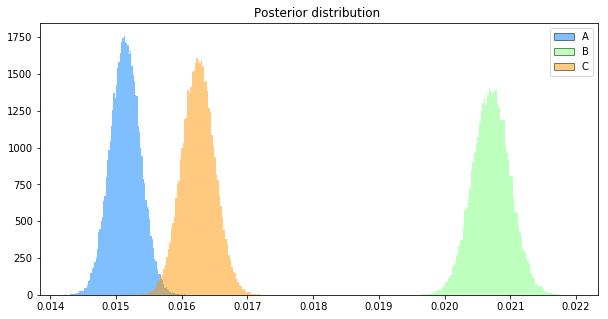

[(0.015141034587728202, 5.332992221848848e-08),
 (0.0207078937798314, 8.243283715216886e-08),
 (0.016250559254538843, 6.199512187766625e-08)]

In [44]:
abtest.update([[imp_a, conv_a], [imp_b, conv_b],[imp_c, conv_c]])
abtest.show_beta()
abtest.mean_ver()

In [45]:
abtest.diff_prob(2,0)

0.99964